In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

In [3]:
import urllib.request
import ssl
import shutil

url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
output_path = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Create an SSL context that does not verify certificates
ssl_context = ssl._create_unverified_context()

with urllib.request.urlopen(url, context=ssl_context) as response, open(output_path, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

print(f"Downloaded to {output_path}")

Downloaded to /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [5]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [8]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output.shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [10]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['acc'])

In [11]:
import os
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/2


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 - 25s - 246ms/step - acc: 0.8760 - loss: 0.3245 - val_acc: 0.9500 - val_loss: 0.1279
Epoch 2/2
100/100 - 24s - 236ms/step - acc: 0.9125 - loss: 0.2137 - val_acc: 0.9640 - val_loss: 0.0965


In [14]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  learning_rate=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

In [15]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/50
100/100 - 24s - 237ms/step - acc: 0.9030 - loss: 0.2428 - val_acc: 0.9570 - val_loss: 0.1135
Epoch 2/50
100/100 - 22s - 224ms/step - acc: 0.9040 - loss: 0.2400 - val_acc: 0.9530 - val_loss: 0.1269
Epoch 3/50
100/100 - 22s - 216ms/step - acc: 0.9115 - loss: 0.2272 - val_acc: 0.9550 - val_loss: 0.1317
Epoch 4/50
100/100 - 22s - 217ms/step - acc: 0.9155 - loss: 0.2258 - val_acc: 0.9540 - val_loss: 0.1332
Epoch 5/50
100/100 - 22s - 216ms/step - acc: 0.9240 - loss: 0.2179 - val_acc: 0.9580 - val_loss: 0.1315
Epoch 6/50
100/100 - 22s - 219ms/step - acc: 0.9195 - loss: 0.2163 - val_acc: 0.9600 - val_loss: 0.1307
Epoch 7/50
100/100 - 22s - 215ms/step - acc: 0.9170 - loss: 0.2106 - val_acc: 0.9590 - val_loss: 0.1290
Epoch 8/50
100/100 - 22s - 219ms/step - acc: 0.9285 - loss: 0.2099 - val_acc: 0.9590 - val_loss: 0.1279
Epoch 9/50
100/100 - 22s - 219ms/step - acc: 0.9165 - loss: 0.2251 - val_acc: 0.9590 - val_loss: 0.1286
Epoch 10/50
100/100 - 22s - 219ms/step - acc: 0.9145 - loss: 0.2

Text(0.5, 1.0, 'Training and validation loss')

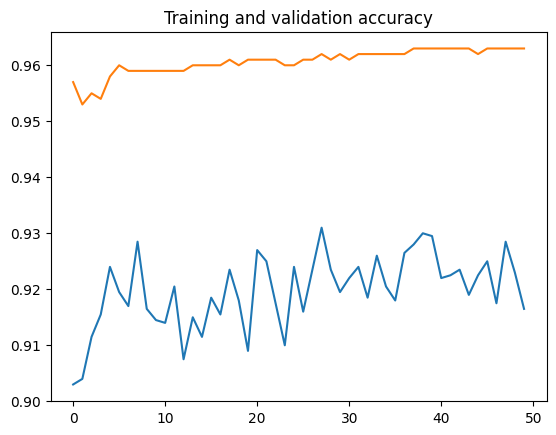

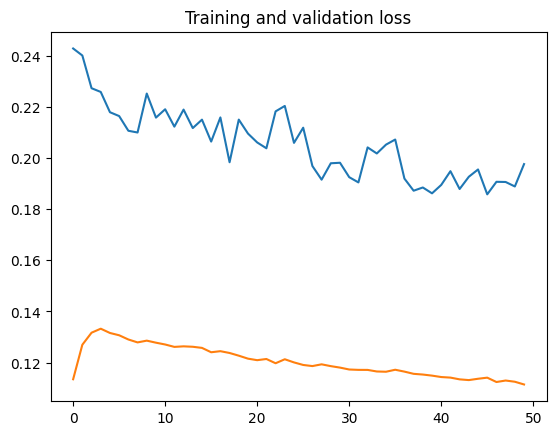

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

: 